# transformer 

## 导入需要的包

In [44]:
import torch
from torch import nn
import copy
import math
from torch.nn import functional
import pandas as pd 
import altair as alt
import time

## 一些辅助函数

In [45]:
def clones(module, N):
    # 将一个同样的module复制N遍存在一个nn.ModuleList中
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

## 文本生成

我们的模型最后输出的向量需要转化为文本，假设模型输出的向量维度为$d_{model}$，词表大小为$vocab$，则用一个向量预测一个词的方法可以看成一个分类问题，输入向量经过一个全连接层，输出维度大小为$vocab$，再经过$softmax$，每个位置代表一个词，最大的即为分类结果。

In [46]:
class Generator(nn.Module):
    
    # d_model为模型输出向量维度
    # vocab为词表大小
    def __init__(self, d_model, vocab):
        super().__init__()
        self.proj = nn.Linear(d_model, vocab)
        
    # x为输入向量，维度为 (*, d_model)
    # 输出为 (*, vocab)
    def forward(self, x):
        return nn.functional.log_softmax(self.proj(x), dim = -1)

上面的`forward`以$x$的最后一维为输入，做投影，选最大位置作为生成的$token$标号。外面套一层$log_softmax$，即先$softmax$再对每个分量求对数。这不影响最大值位置的判断，但有利于在训练时计算损失函数（分类问题一般用交叉熵）。

In [47]:
# 尝试使用一下该Module
g = Generator(100, 10)
x = torch.randn(5, 100)
y = g(x)
y

tensor([[-2.4475, -1.6763, -3.2895, -2.4946, -2.4555, -2.1420, -2.0029, -2.5648,
         -2.0516, -2.7648],
        [-2.9417, -1.5999, -2.4268, -3.3342, -1.5186, -2.8202, -2.1703, -2.6748,
         -2.5429, -2.5131],
        [-2.2006, -2.6809, -2.9692, -2.7422, -2.7097, -1.9912, -2.2059, -1.6143,
         -2.5849, -2.1429],
        [-2.7375, -2.3929, -2.3841, -2.0518, -2.7521, -3.5235, -1.9262, -2.6435,
         -1.8096, -1.9011],
        [-3.6365, -2.0155, -2.5021, -2.2577, -1.8152, -3.0686, -2.0642, -2.6170,
         -1.9061, -2.3433]], grad_fn=<LogSoftmaxBackward0>)

In [48]:
_, tokens = torch.max(y, dim=-1)
tokens

tensor([1, 4, 7, 8, 4])

## LayerNorm

LayerNorm是对每一个样本的各个维度进行归一化，不像$BatchNorm$是对一个批量的样本的同一个维度进行归一化。
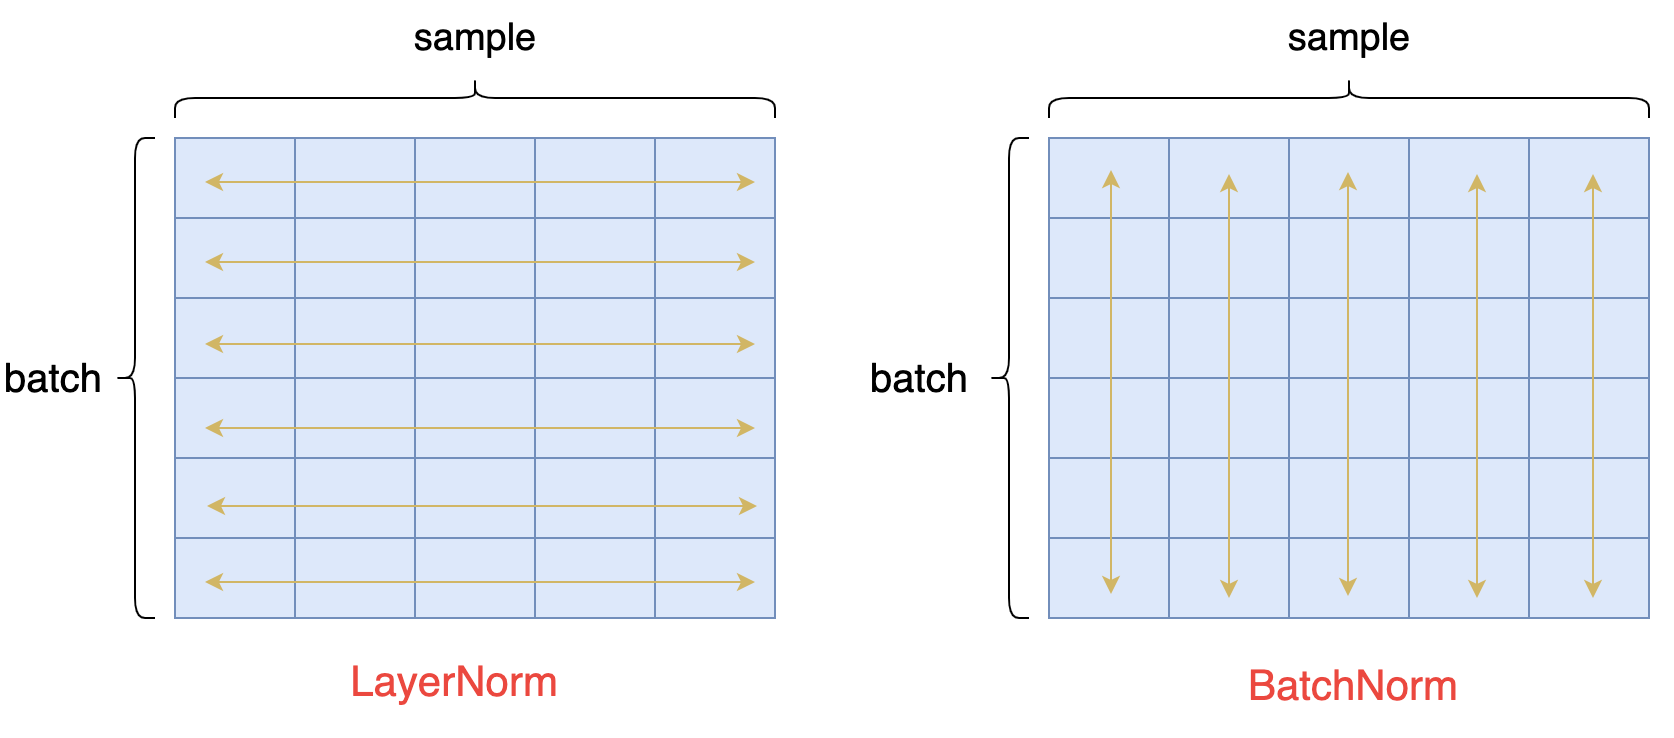

$LayerNorm$的计算公式如下
$$
y = \frac{x-E(x)}{\sqrt{Var(x)+\epsilon}}* \gamma + \beta
$$
其中$\epsilon$是为了防止$Var(x)$为0而加上的一个小值，$\gamma$和$\beta$为可学习参数，可以是$tensor$也可以是标量，在后面的实现中使用$tensor$.

In [49]:
class LayerNorm(nn.Module):
    
    # 该实现默认输入x的最后一维为feature，即默认样本为一维
    # 维度为feature_size
    def __init__(self, feature_size, eps=1e-6):
        super().__init__()
        self.eps = eps # 给Var(x)加一个小量，防止方差为0
        self.gamma = nn.Parameter(torch.ones(feature_size))
        self.beta = nn.Parameter(torch.zeros(feature_size))
        
    def forward(self, x):
        E = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True)
        return self.gamma * (x - E) / torch.sqrt(var + self.eps)\
            + self.beta

随便计算一个例子

In [50]:
x = torch.randn(2,2,4)
x

tensor([[[ 0.2741,  1.8763,  0.2767,  1.4486],
         [ 0.5064, -1.1761,  0.1747, -0.0958]],

        [[-0.1504, -1.2786, -0.5856, -1.4224],
         [ 0.1142,  0.6921,  0.5609, -1.6476]]])

In [51]:
ln = LayerNorm(x.size(-1))
y = ln(x)
y

tensor([[[-0.8477,  1.1070, -0.8446,  0.5852],
         [ 0.8979, -1.4117,  0.4426,  0.0713]],

        [[ 1.1867, -0.7020,  0.4581, -0.9429],
         [ 0.1706,  0.7055,  0.5841, -1.4601]]], grad_fn=<AddBackward0>)

来看看广播机制如何保证$\gamma$会乘到最后一个维度的各个向量上，$\beta$同理

In [52]:
x = torch.tensor([i*1.0 for i in range(2*3*4)])
x = x.reshape((2, 3, 4))
print(f'x: {x}')
gamma = torch.arange(0, x.size(-1))
print(f'gamma: {gamma}')
x * gamma

x: tensor([[[ 0.,  1.,  2.,  3.],
         [ 4.,  5.,  6.,  7.],
         [ 8.,  9., 10., 11.]],

        [[12., 13., 14., 15.],
         [16., 17., 18., 19.],
         [20., 21., 22., 23.]]])
gamma: tensor([0, 1, 2, 3])


tensor([[[ 0.,  1.,  4.,  9.],
         [ 0.,  5., 12., 21.],
         [ 0.,  9., 20., 33.]],

        [[ 0., 13., 28., 45.],
         [ 0., 17., 36., 57.],
         [ 0., 21., 44., 69.]]])

## Sublayer

transformer一个block包含两个子层，分别是multi-headed attention和feed-forward networks，子层之间连接还需要加一个残差连接和LayerNorm，如下图所示
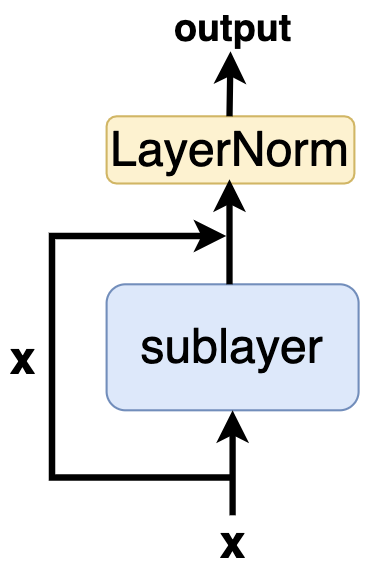
下面编写包裹子层的代码

In [53]:
class SublayerConnection(nn.Module):
    
    def __init__(self, size, dropout):
        super().__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, sublayer):
        sub_out = sublayer(x)
       # res = x + self.dropout(sub_out)
#         print(f'res: {res}')
        return self.norm(x + self.dropout(sub_out))
    
# 测试一下行为正不正确
x = torch.tensor([i*1.0 for i in range(15)])
x = x.reshape((3,5))
print(f'x: {x}')
sc = SublayerConnection(5, 0.2)
sc.eval()
relu = nn.ReLU()
y = sc(x, relu)
y

x: tensor([[ 0.,  1.,  2.,  3.,  4.],
        [ 5.,  6.,  7.,  8.,  9.],
        [10., 11., 12., 13., 14.]])


tensor([[-1.2649, -0.6325,  0.0000,  0.6325,  1.2649],
        [-1.2649, -0.6325,  0.0000,  0.6325,  1.2649],
        [-1.2649, -0.6325,  0.0000,  0.6325,  1.2649]], grad_fn=<AddBackward0>)

### 生成mask
在做训练时，不希望模型看到当前位置之后输入，例如第10个位置的输入在做self attention时只能看到0~10这些位置的输入，为此要生成对应的mask

In [54]:
def subsequent_mask(size):
    return torch.tril(torch.ones((size, size))).type(torch.uint8)

subsequent_mask(8)

tensor([[1, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1]], dtype=torch.uint8)

In [55]:
def example_mask():
    LS_data = pd.concat(
        [
            pd.DataFrame(
                {
                    "Subsequent Mask": subsequent_mask(20)[x, y].flatten(),
                    "Window": y,
                    "Masking": x,
                }
            )
            for y in range(20)
            for x in range(20)
        ]
    )

    return (
        alt.Chart(LS_data)
        .mark_rect()
        .properties(height=250, width=250)
        .encode(
            alt.X("Window:O"),
            alt.Y("Masking:O"),
            alt.Color("Subsequent Mask:Q", scale=alt.Scale(scheme="viridis")),
        )
        .interactive()
    )

example_mask()

alt.Chart(...)

### attention
attention机制部分包含普通的scaled dot product attention和基于此的multi-head attention，关于tensor的内部构造，看到两篇不错的文章，一篇讲view和reshape的区别，另一篇讲size和stride的作用
- https://zhuanlan.zhihu.com/p/464384583
- https://funian788.github.io/post/pytorch-view-reshape/

注意力机制的公式如下图
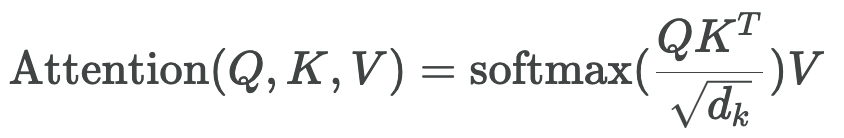

In [75]:
def attention(queries, keys,values, mask=None, dropout=None):
    # 此处的mask是对注意力得分做的
    # 形状和Q*K^T一致（有广播机制）
    # 假设Q, K, V的维度都一样，记作d_k
    d_k = queries.size(-1)
    scores = torch.bmm(queries, keys.transpose(-2,-1)) / math.sqrt(d_k)
    if mask is not None:
        print(f'mask shape:{mask.shape} mask: {mask}')
        print(f'score shape:{scores.shape} scores: {scores}')
        scores.masked_fill(mask == 0, -1e9)
    p_attn = scores.softmax(dim=-1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.bmm(p_attn, values), p_attn

Q = torch.tensor([[[1, 2, 3], 
                   [2, 4, 6]],
                  
                  [[7, 8, 9], 
                   [10, 11, 12]]])
K = torch.tensor([[[0, 1, 0],
                   [2, 0, 0]],
                  
                  [[0, 1, 1], 
                   [3, 1, 1]]])
V = torch.tensor([[[0.1, 0.2, 0.3], 
                   [0.4, 0.5, 0.6]],
                  
                  [[0.7, 0.8, 0.9], 
                   [1.0, 1.1, 1.2]]])

output, attn = attention(Q, K, V)
output, attn

(tensor([[[0.2500, 0.3500, 0.4500],
          [0.2500, 0.3500, 0.4500]],
 
         [[1.0000, 1.1000, 1.2000],
          [1.0000, 1.1000, 1.2000]]]),
 tensor([[[5.0000e-01, 5.0000e-01],
          [5.0000e-01, 5.0000e-01]],
 
         [[5.4257e-06, 9.9999e-01],
          [3.0047e-08, 1.0000e+00]]]))

多头注意力机制是为了能让一个问题同时关注不同方面的信息，即将一个$Q$变为好几个$Q$，$K$,$V$同理，用图片表示如下
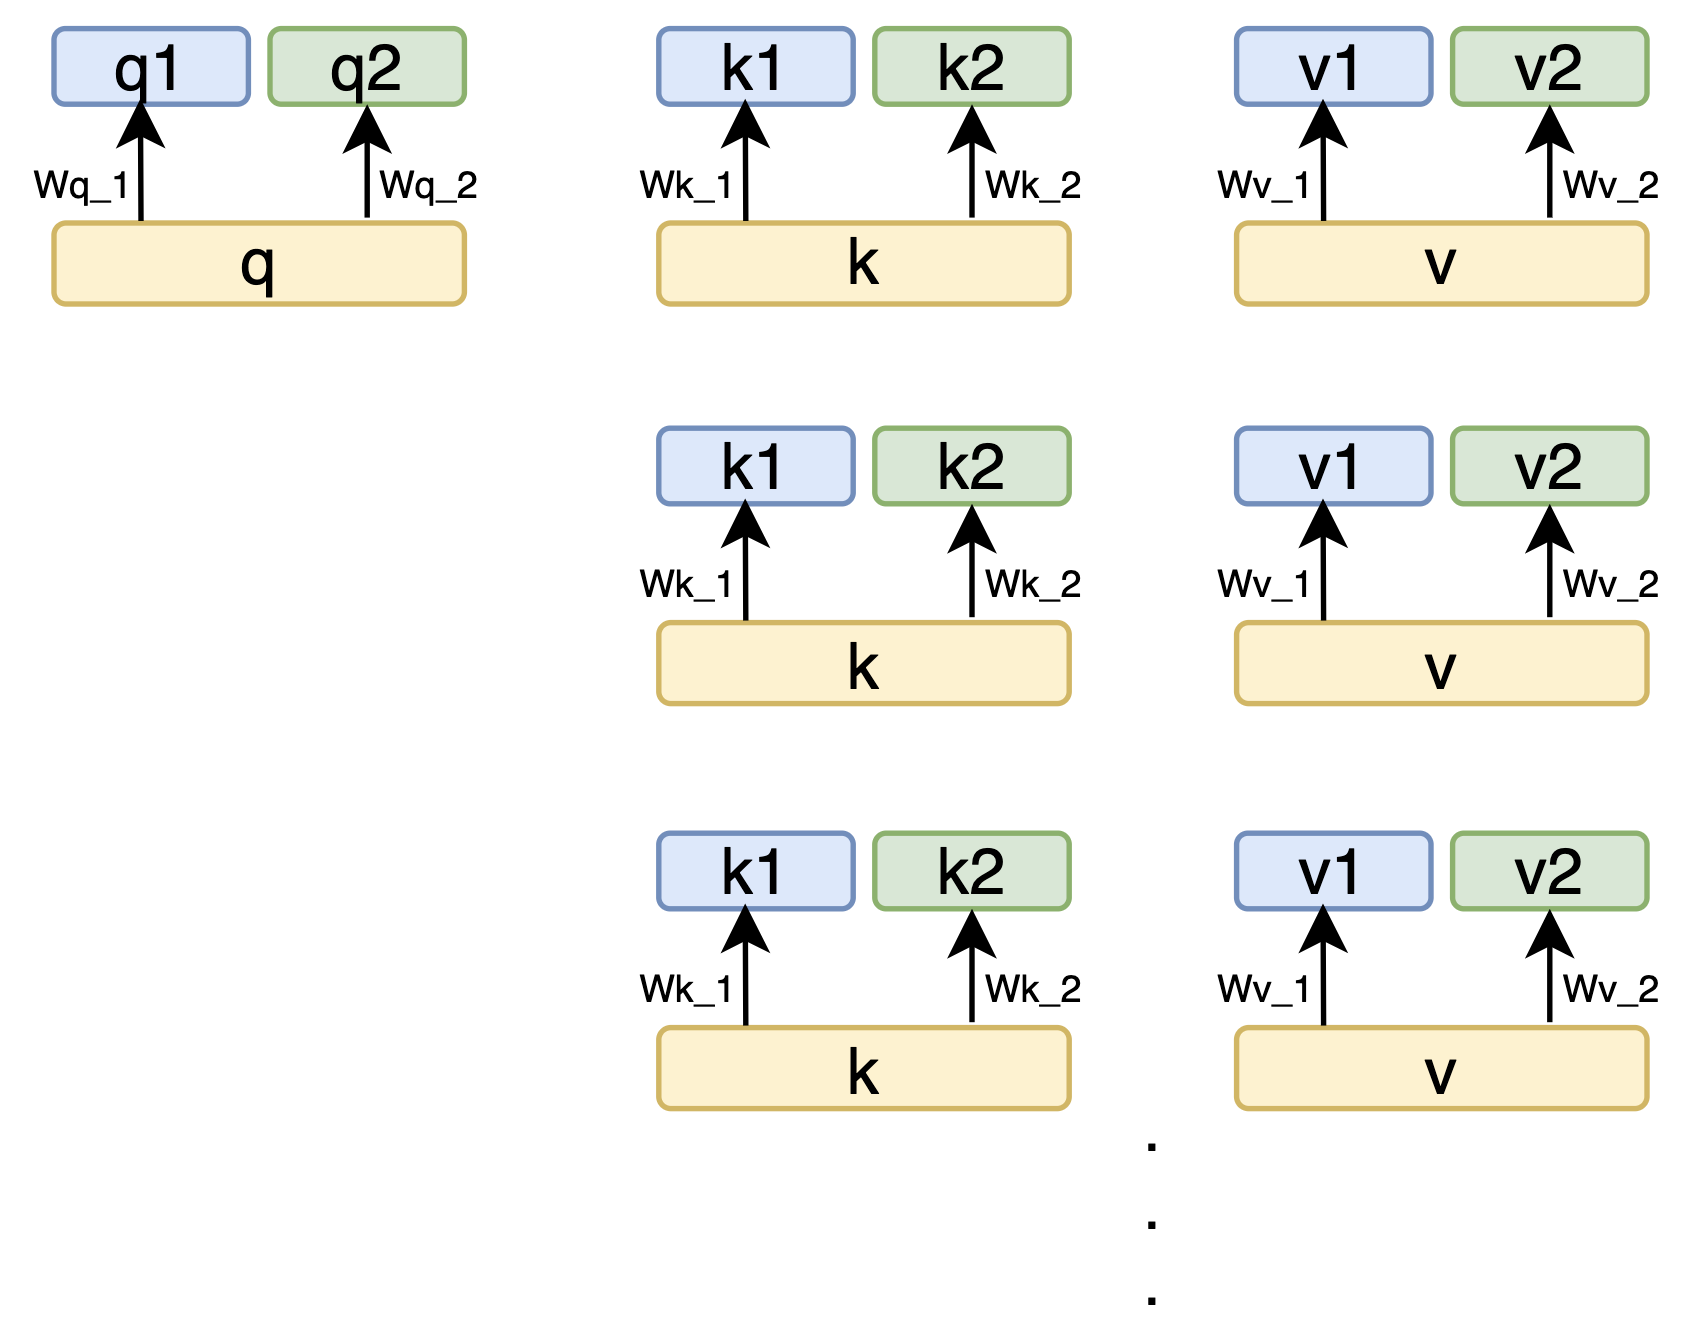
以二头的注意力机制为例，原先的每一个q,k,v分别乘以两个矩阵得到两个对应的q,k,v，即两个头，然后每个头做自注意力机制，操作和前述一致，即图中所有蓝色部分做注意力机制得到结果，接着绿色部分再做一遍得到另一个结果，两个结果拼起来再做一次投影（线性变换）就得到多头注意力的结果，描述如下图
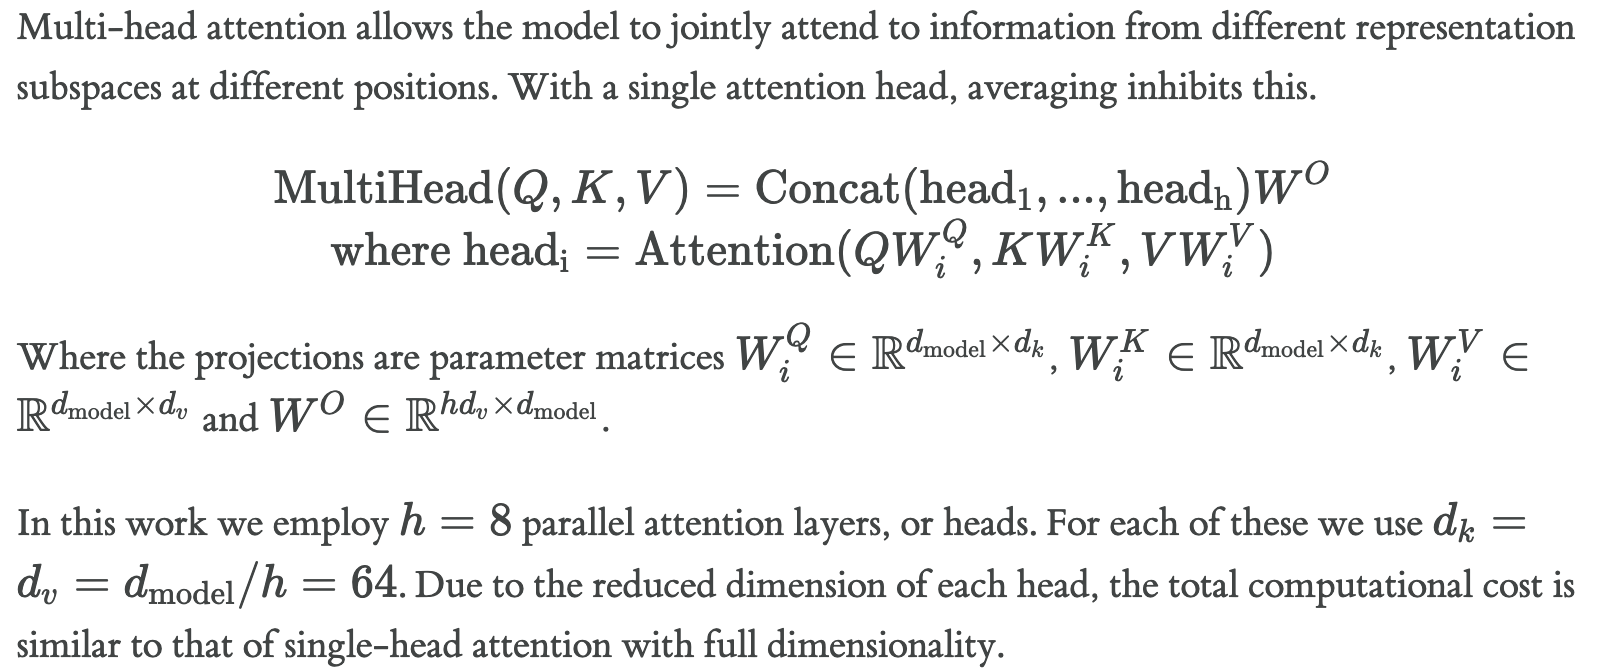
注意在原论文中q,k,v都是$d_{model}=512$维的，头数$h=8$，每一个头对应的q,k,v维度为原来的$\frac{1}{8}$，这是为了让计算速度和单头注意力机制保持一致，另外再实现时有些trick，不需要单独算出每个头再拼接再投影。

记$Q\in \mathbb{R}^{N_Q\times d_{model}}$，$K\in \mathbb{R}^{N_K\times d_{model}}$，$V\in \mathbb{R}^{N_V\times d_{model}}$，以$Q$的计算为例，$Q$的$h$个头分别为
$$
QW^Q_1,QW^Q_2\dots QW^Q_h
$$
其中$W^Q_i\in \mathbb{R}^{d_{model}\times d_k}, d_k=d_{model}/h$。为了同时算出$h$个头，从数学上可以看出
$$
\begin{bmatrix}
QW^Q_1 && QW^Q_2 && \dots && QW^Q_h
\end{bmatrix}
=Q\begin{bmatrix}
W^Q_1 && W^Q_2 && \dots && W^Q_h
\end{bmatrix}
$$
所以$h$次矩阵乘法可以变为一次矩阵乘法，记
$$
W^Q=\begin{bmatrix}
W^Q_1 && W^Q_2 && \dots && W^Q_h
\end{bmatrix} \\ 
W^Q \in \mathbb{R}^{d_{model}\ \ \ \times d_{model}}
$$
下面参考《动手学深度学习》中的相关章节 https://zh.d2l.ai/chapter_attention-mechanisms/multihead-attention.html 实现多头注意力机制

In [57]:
class MultiHeadedAttention(nn.Module):
    
    def __init__(self, h, d_model, dropout=0.1, bias=False):
        super().__init__()
        self.W_q = nn.Linear(d_model, d_model, bias=bias)
        self.W_k = nn.Linear(d_model, d_model, bias=bias)
        self.W_v = nn.Linear(d_model, d_model, bias=bias)
        
        # h个头拼接后再过W_o
        self.W_o = nn.Linear(d_model, d_model, bias=bias)
        
        self.dropout = nn.Dropout(dropout)
        self.d_k = d_model // h
        self.h = h
        assert d_model % h == 0
    
    def forward(self, Q, K, V, mask=None):
        # Q: (b, N_q, d_model) 
        # b: batch size 
        # N_q: Number of Q
        # d_model: dimension of q
        Q = self.W_q(Q) # (b, N_q, h*d_k)
        Q = self.transpose_qkv(Q) # (b*h, N_q, d_k)
        
        K = self.W_k(K)
        K = self.transpose_qkv(K)
        
        V = self.W_v(V)
        V = self.transpose_qkv(V)
        
        # apply single head attention to echo head
        # attn_weight: (b*h, N_q, N_k)
        out, self.attn_weight = attention(Q, K, V, mask, dropout=self.dropout)
        
        # concat and do linear transformation
        return self.W_o(self.transpose_output(out))
        
    def transpose_qkv(self, X):
        # X: (b, N_qkv, h*d_k)
        
        # split eche heads
        # X: (b, N_qkv, h, d_k)
        X = X.reshape(X.size(0),X.size(1),self.h,-1)
        
        # X: (b, h, N_qkv, d_k)
        # to ensure that qkv in the same
        # head to do attention operation
        X = X.transpose(1,2)
        
        # X: (b*h, N_qkv, d_k)
        # reshape to meet the requirement of
        # input shape of attention
        return X.reshape(-1, X.size(-2), X.size(-1))
    
    def transpose_output(self, X):
        # X: (b*h, N_q, d_k)
        
        # split batch size and heads
        # X: (b, h, N_q, d_k)
        X = X.reshape(-1, self.h, X.size(-2), X.size(-1))
        
        # transpose and merge last two dimension to 
        # concat echo head
        # X: (b, N_q, h, d_k)->(b, N_q, h*d_k)
        X = X.transpose(1,2)
        return X.reshape(X.size(0), X.size(1), -1)

上面代码中数据的维度变化可以参考下图
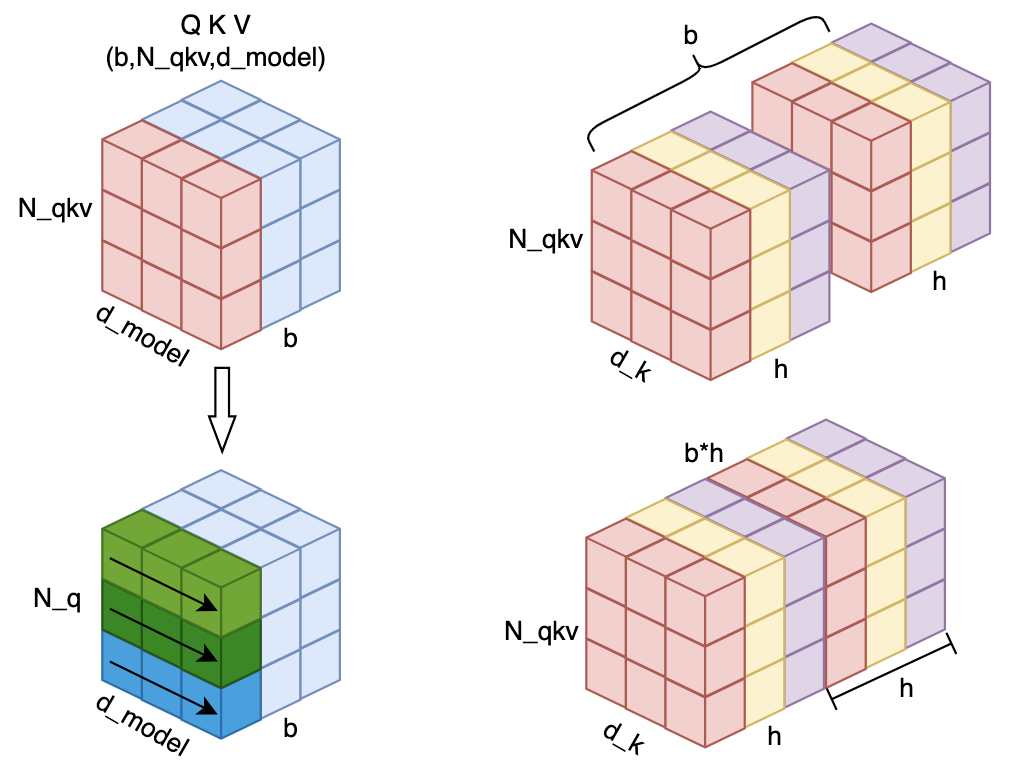

图中左边那一列是正常的单头注意力机制，右边是将多个头变为单个头来直接使用单头注意力机制时数据的布局和维度变化。

和torch的对比一下看看对不对吧

In [58]:
b = 2
n_qkv = 2
d_model = 2
h = 2

my_attn = MultiHeadedAttention(h, d_model, 0)
torch_attn = nn.MultiheadAttention(d_model,h,bias=False,batch_first=True)

# Q = torch.randn(b,n_qkv,d_model)
# K = torch.randn(b,n_qkv,d_model)
# V = torch.randn(b,n_qkv,d_model)

Q = torch.ones(b,n_qkv,d_model)
K = torch.ones(b,n_qkv,d_model)
V = torch.ones(b,n_qkv,d_model)

print(f"Q: {Q} \nK: {K} \nV:{V}")

def constant_init(c):
    def initiate(module):
        if hasattr(module, 'weight') and module.weight is not None:
            nn.init.constant_(module.weight, c)
            
        if hasattr(module, 'bias') and module.bias is not None:
            nn.init.zeros_(module.bias)
    
    return initiate

my_attn.apply(constant_init(1.0))
my_attn.eval()
torch_attn.apply(constant_init(1.0))
torch_attn.eval()

o1 = my_attn(Q,K,V)
a1 = my_attn.attn_weight
o2,a2 = torch_attn(Q,K,V)
print(f"o1:{o1} \no2:{o2}\nsame: {torch.allclose(o1,o2)}")
print(f"a1: {a1} \na2: {a2}")

Q: tensor([[[1., 1.],
         [1., 1.]],

        [[1., 1.],
         [1., 1.]]]) 
K: tensor([[[1., 1.],
         [1., 1.]],

        [[1., 1.],
         [1., 1.]]]) 
V:tensor([[[1., 1.],
         [1., 1.]],

        [[1., 1.],
         [1., 1.]]])
o1:tensor([[[4., 4.],
         [4., 4.]],

        [[4., 4.],
         [4., 4.]]], grad_fn=<UnsafeViewBackward0>) 
o2:tensor([[[-1.7250, -1.7250],
         [-1.7250, -1.7250]],

        [[-1.7250, -1.7250],
         [-1.7250, -1.7250]]], grad_fn=<TransposeBackward0>)
same: False
a1: tensor([[[0.5000, 0.5000],
         [0.5000, 0.5000]],

        [[0.5000, 0.5000],
         [0.5000, 0.5000]],

        [[0.5000, 0.5000],
         [0.5000, 0.5000]],

        [[0.5000, 0.5000],
         [0.5000, 0.5000]]], grad_fn=<SoftmaxBackward0>) 
a2: tensor([[[0.5000, 0.5000],
         [0.5000, 0.5000]],

        [[0.5000, 0.5000],
         [0.5000, 0.5000]]], grad_fn=<DivBackward0>)


好吧我也不知道torch内部是怎么实现的，为什么每次运行结果o2都不一样，看来不能对比了。

### Position-wise Feed-Forward Networks

子层中除了多头注意力机制还有一层是Position-wise Feed-Forward Networks，即每一个位置的输入（最后一维）都过一层一样的前馈神经网络，公式如下
$$
FFN(x)=max(0,xW_1+b_1)W_2+b_2
$$
若将线性变换记作
$$
Linear(x) = xW+b
$$
则$FFN$等价于
$$
FFN(x)=Linear_2(ReLU(Linear_1(x)))
$$

In [59]:
class FFN(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        self.w1 = nn.Linear(d_model, d_ff)
        self.w2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        return self.w2(self.dropout(self.w1(x).relu()))
    
ffn = FFN(5,10)
x = torch.randn(2,3,5)
y = ffn(x)
print(f"x:{x} \ny:{y}")

x:tensor([[[ 1.0183e+00,  8.4581e-01, -4.1352e-01,  6.1443e-02, -2.2703e-03],
         [ 5.4795e-01, -2.3634e-01, -9.3410e-01,  2.8938e-01,  8.7517e-01],
         [ 6.7972e-01, -8.3863e-01, -5.0549e-01,  2.0015e+00, -3.7575e-03]],

        [[-2.0534e+00, -6.0726e-01, -4.2643e-01,  2.5379e-02,  1.2316e+00],
         [-2.5921e+00,  8.4049e-01,  3.6467e-01,  3.3783e-01,  1.3110e+00],
         [ 1.4319e+00, -1.5930e-02,  1.2822e+00, -5.8971e-01, -7.2394e-01]]]) 
y:tensor([[[-0.7062,  0.1907, -0.5915, -0.4576, -0.1201],
         [-0.5948,  0.1761, -0.3339, -0.4251, -0.1283],
         [-0.6106,  0.4862, -0.0869, -0.4811, -0.3912]],

        [[-0.3553, -0.0502,  0.6077,  0.0945, -0.3827],
         [-0.2320,  0.1374,  0.1020, -0.1206, -0.2036],
         [-0.5216,  0.5723, -0.0995, -0.3276, -0.4620]]],
       grad_fn=<ViewBackward0>)


## Embeddings

In [60]:
class Embeddings(nn.Module):
    # d_model: 词嵌入向量维度
    # vocab: 词表大小
    def __init__(self, d_model, vocab, padding_idx=0):
        super().__init__()
        self.emb = nn.Embedding(vocab, d_model, padding_idx=padding_idx)
        self.d_model = d_model
        
    def forward(self, x):
        # 这里我也不太清楚为什么要 * sqrt(d_model)
        return self.emb(x) * math.sqrt(d_model)

在这篇文章（https://towardsdatascience.com/how-to-code-the-transformer-in-pytorch-24db27c8f9ec ）中的说法是这样的
> The reason we increase the embedding values before addition is to make the positional encoding relatively smaller. This means the original meaning in the embedding vector won’t be lost when we add them together.

使用例子如下

In [61]:
emb = Embeddings(4, 10, 0)
x = torch.tensor([0,4,9,2,3]) # token 标号
y = emb(x)
print(f"x: {x} \ny:{y}")

x: tensor([0, 4, 9, 2, 3]) 
y:tensor([[ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.6624, -0.2851, -2.0593,  0.0329],
        [ 0.2284, -1.2620, -1.9695, -0.2191],
        [ 1.0094,  0.6729,  1.0508,  0.9655],
        [ 0.1489, -0.4020, -0.1855, -1.4371]], grad_fn=<MulBackward0>)


## Positional Encoding

公式如下图所示
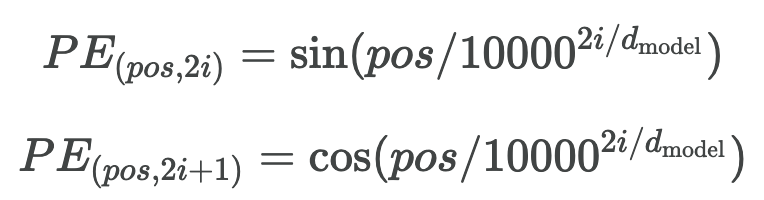

注意在计算$10000^x$时可以用以下方法
$$
10000^x = e^{ln(10000)x} \\
\frac{1}{10000^x} = e^{-ln(10000)x}
$$

In [62]:
class PositionalEncoding(nn.Module):
    # max_len: 句子最长长度
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        # 每行为一个位置编码
        # 一个句子最多max_len长
        # 故有max_len个位置编码
        # 若某个embedding位置为3(从0开始算)
        # 对应位置编码为pe[3]
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len).reshape((max_len, -1))
        div_term = torch.exp((-math.log(10000))*torch.arange(0, d_model, 2)/d_model)
        
        pe[:,0::2] = torch.sin(pos*div_term)
        pe[:,1::2] = torch.cos(pos*div_term)
        
        self.register_buffer("pe", pe)
        
    def forward(self, x):
        x = x + self.pe[:x.size(-2)].requires_grad_(False)
        return self.dropout(x)
    
def example_positional():
    pe = PositionalEncoding(20, 0)
    y = pe.forward(torch.zeros(1, 100, 20))

    data = pd.concat(
        [
            pd.DataFrame(
                {
                    "embedding": y[0, :, dim],
                    "dimension": dim,
                    "position": list(range(100)),
                }
            )
            for dim in [4, 5, 6, 7]
        ]
    )

    return (
        alt.Chart(data)
        .mark_line()
        .properties(width=800)
        .encode(x="position", y="embedding", color="dimension:N")
        .interactive()
    )

example_positional()

alt.Chart(...)

## Encoder Decoder
transformer也采用encoder decoder架构，encoder读取一个sequence编码为中间状态，交给decoder来解码出一串新的sequence，结构图如下
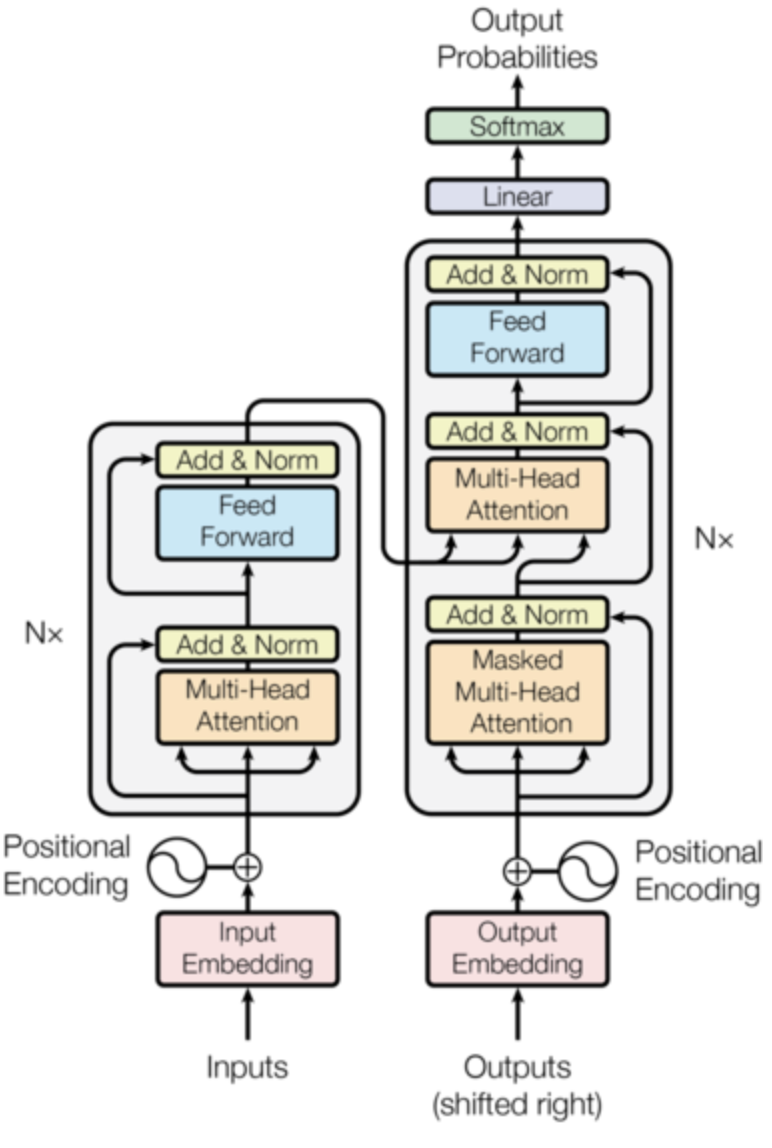

In [63]:
class Encoder(nn.Module):
    # 由N个encoder block组成
    # 即参数中的layer
    def __init__(self, layer, N):
        super().__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, mask=None):
        x = self.norm(x)
        for layer in self.layers:
            x = layer(x, mask)
        return x

In [64]:
class EncoderBlock(nn.Module):
    def __init__(self, size, multihead_attn, ffn, dropout):
        super().__init__()
        # MultiheadAttention module
        self.attn = multihead_attn
        # Feedforward module
        self.ffn = ffn
        
        # just d_model
        self.size = size
        self.sublayers = clones(SublayerConnection(size, dropout), 2)
        
    def forward(self, x, mask):
        # sublayer1 is Multihead Attention
        # note that Q K V here is all the same(words embedding)
        x = self.sublayers[0](x, lambda x: self.attn(x,x,x,mask))
        return self.sublayers[1](x, self.ffn)

In [65]:
class Decoder(nn.Module):
    def __init__(self, layer, N):
        super().__init__()
        self.norm = LayerNorm(layer.size)
        self.layers = clones(layer, N)
        
    def forward(self, x, memory, src_mask, tgt_mask):
        x = self.norm(x)
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return x

In [66]:
class DecoderBlock(nn.Module):
    def __init__(self, size, tgt_attn, src_attn, ffn, dropout):
        super().__init__()
        self.size = size
        
        # 上图中的Masked Multi-Head Attention部分
        self.tgt_attn = tgt_attn
        
        # 上图中的中间的Multi-Head Attention部分
        # 接收encoder的k和v
        self.src_attn = src_attn
        
        # feedforward
        self.ffn = ffn
        
        self.sublayers = clones(SublayerConnection(size, dropout), 3)
        
    def forward(self, x, memory, src_mask, tgt_mask):
        m = memory
        [s1, s2, s3] = [self.sublayers[i] for i in range(3)]
        x = s1(x, lambda x: self.tgt_attn(x,x,x,tgt_mask))
        x = s2(x, lambda x: self.src_attn(x,m,m,src_mask))
        return s3(x, self.ffn)

把encoder和decoder合起来变为一个整体

In [67]:
class EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator
        
    # src: (b, max_len) source sentence
    # b: batch size; max_len: max length of batch of sentence
    # sentence represented by tokens, token is a number
    # tgt is similar
    # src_mask and tgt mask will pass to encoder and decoder
    def forward(self, src, tgt, src_mask, tgt_mask):
        memory = self.encode(src, src_mask)
        return self.decode(memory, src_mask, tgt, tgt_mask)
        
    def encode(self, src, src_mask=None):
        emb = self.src_embed(src) # (b, max_len)->(b,max_len,d_emb)
        return self.encoder(emb, src_mask)
    
    def decode(self, memory,src_mask, tgt, tgt_mask):
        emb = self.tgt_embed(tgt)
        return self.decoder(emb, memory, src_mask, tgt_mask)

## Full Model
将上面实现的模型的各个部分拼起来即得到最终模型

In [68]:
def make_model(
    src_vocab, tgt_vocab, N=6, d_model=512, d_ff=2048, h=8, dropout=0.1
)->EncoderDecoder:
    # 源语言词表大小 目标语言词表大小
    # 堆叠层数 模型输出向量维度
    # FFN中间层大小
    # 多头注意力头数
    # dropout 概率
    c = copy.deepcopy
    attn = MultiHeadedAttention(h,d_model, dropout)
    ff = FFN(d_model, d_ff, dropout)
    pos = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(
        Encoder(EncoderBlock(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderBlock(d_model, c(attn), c(attn), c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(pos)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(pos)),
        Generator(d_model, tgt_vocab),
    )
    
    # This was important from their code.
    # Initialize parameters with Glorot / fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    return model

### 测试模型

In [69]:
# 创建模型
test_model = make_model(11, 11, 2)
test_model.eval()
src = torch.tensor([[1,2,3,4,5,6,7,8,9,10]]) # 源句子 (b,len)
memory = test_model.encode(src) # 编码 (b,len)->(b,len,d_model)->(b,len,d_model)
memory

tensor([[[-0.7306,  1.5981, -0.6936,  ...,  1.0320,  0.8585,  1.2148],
         [ 0.0183,  1.3452,  0.1112,  ...,  0.9696,  0.6358,  1.3601],
         [ 0.3838,  0.2597, -0.0031,  ...,  1.0046,  0.5298,  1.1949],
         ...,
         [ 0.1899,  1.7900, -0.2240,  ...,  0.8176,  0.7753,  1.3416],
         [ 0.2021,  0.9758,  0.1568,  ...,  0.6115,  0.9677,  1.1679],
         [-0.2900,  0.5481,  0.0192,  ...,  0.6209,  0.9094,  0.9810]]],
       grad_fn=<AddBackward0>)

In [70]:
# 上面得到了编码器的输出memory
# 用解码器输出下一个token
tgt = torch.tensor([[0]]) # (b, len)

# out: (b,len,d_model)
out = test_model.decode(memory, None, tgt, subsequent_mask(tgt.size(-1)))

# out[:,-1,:]维度为(b,vocab) 
# 因为第维度1上的索引为-1，只有一个，(b,1,vocab)中间的1会被squeeze掉
prob = test_model.generator(out[:,-1,:])

prob, out[:,-1].shape, out.shape

(tensor([[-3.0065, -2.0586, -3.3195, -3.5715, -3.1078, -3.2693, -3.8087, -2.0913,
          -1.1916, -2.9213, -1.7568]], grad_fn=<LogSoftmaxBackward0>),
 torch.Size([1, 512]),
 torch.Size([1, 1, 512]))

In [71]:
# prob: (b,vocab)
# next_word: (b) 记录着每个batch的预测下一个token
_, next_word = torch.max(prob, dim = -1)
next_word

tensor([8])

In [72]:
# 将next_word: (b) reshape为 (b,1)方便拼接
next_word = next_word.unsqueeze(-1)
next_word

tensor([[8]])

In [73]:
# 拼接到原来的句子上
tgt = torch.cat((tgt, next_word), dim=1)
tgt

tensor([[0, 8]])

In [74]:
# 接下来尝试一下批量产生下一个token
# src为源句子 src: (b, max_len)
# n为产生token数目
def inference_test(src, src_mask, n):
    test_model = make_model(11, 11, 3)
    test_model.eval()
    
    memory = test_model.encode(src, src_mask)
    tgt = torch.zeros(src.size(0),1,dtype=torch.long)
    for _ in range(n):
        # tgt: (b,len)
        # out:(b,len,d_model)
        out = test_model.decode(memory, src_mask, tgt, subsequent_mask(tgt.size(-1)))
        prob = test_model.generator(out[:,-1]) # prob: (b,vocab)
        _, next_word = torch.max(prob, dim=-1) # next_word: (b)
        tgt = torch.cat((tgt, next_word.unsqueeze(-1)),dim = -1)
        print(tgt)
        
src = torch.tensor([[1,2,3,4,5]])
inference_test(src, None, 20)

tensor([[0, 3]])
tensor([[0, 3, 3]])
tensor([[0, 3, 3, 3]])
tensor([[0, 3, 3, 3, 3]])
tensor([[0, 3, 3, 3, 3, 3]])
tensor([[0, 3, 3, 3, 3, 3, 3]])
tensor([[0, 3, 3, 3, 3, 3, 3, 3]])
tensor([[0, 3, 3, 3, 3, 3, 3, 3, 3]])
tensor([[0, 3, 3, 3, 3, 3, 3, 3, 3, 3]])
tensor([[0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]])
tensor([[0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]])
tensor([[0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]])
tensor([[0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]])
tensor([[0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]])
tensor([[0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]])
tensor([[0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]])
tensor([[0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]])
tensor([[0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]])
tensor([[0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]])
tensor([[0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]])


为啥几乎每次预测结果都一样呀啊这...写到这里时有一些疑惑，先记录下来:

本来我感觉src_mask在transformer里没有什么用，毕竟encoder作为输入，应该每个位置都得看一遍吧，整个架构里应该只有decoder需要mask，目的是为了遮住后面的答案防止当前输出直接取到了后面的答案。

但转念一想，在同时只有一个输入时src_mask确实没什么用，但有一个batch作为输入时，src_mask就有用了呀，比如一个小批量（批量为2）如下
```python
[['I', 'am', 'a', 'boy'],
 ['She', 'is', 'a', 'lovely', 'girl']]
```
为了方便直接将`token`记为英语单词了，`tensor`必须是对齐的，意思是说比如一个`shape`为`(3,4)`的矩阵，每行就一定有4列，不能一行2列一行三列一行四列。所以在处理上面的输入时，会给句子加`padding`补到和最长的句子一样，即
```python
[['I', 'am', 'a', 'boy', 'padding'],
 ['She', 'is', 'a', 'lovely', 'girl']]
```
但`padding`是无意义的，不希望它影响结果，那怎么办，只能使用`mask`把`padding`盖住，过`self attention`时，第一句话的`mask`为:
```python
[[1,1,1,1,0],
 [1,1,1,1,0],
 [1,1,1,1,0],
 [1,1,1,1,0],
 [0,0,0,0,0]]
```
即每个位置都只看前4个位置的单词，不看padding，padding那个位置不管了，直接全0（我自己写的全0，不知道后面代码怎么样 *附：看到后面代码了，后面代码对于padding那些行填写也和前面的行一样* ）。所以说src_mask就是用来遮蔽`padding`的。

但是在annotated transformer中`EncoderDecoder`的实现又非常的奇怪
```python
class EncoderDecoder(nn.Module):
    """
    A standard Encoder-Decoder architecture. Base for this and many
    other models.
    """

    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator

    def forward(self, src, tgt, src_mask, tgt_mask):
        "Take in and process masked src and target sequences."
        return self.decode(self.encode(src, src_mask), src_mask, tgt, tgt_mask)

    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)

    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)
```
注意看上面的`forward`居然在encode和decode时用的是同一个`src_mask`，`mask`对于一个样本来说形状应该是`(N_q,N_kv)`，每一行代表一个`q`应当看那些`kv`，对于`encoder`来说`qkv`都是`encoder`的输入，那`mask`应该是`(N_q,N_q)`其中`N_q`为句子长度。但对于`decoder`来说，在`decoder block`的中间那个`multihead attention`那里，q来自于`decoder`，而`kv`用的是`encoder`的输出，那对于一个样本来说，`mask`的形状应该是`(decoder输入句子长度，encoder输入句子长度)`，为什么代码里两个`src_mask`用的是同一个`mask`呢？

# Training
## batch and mask

首先将每次训练用到的batch抽象为一个类，该类用来存储一个batch的样本和对应的mask，在该节会看到上一节末尾问题的答案。

来看看对源句子的mask，拿一个样本举例，mask应该为
$$
mask = \begin{pmatrix}
1 & 1 & \dots & 1& 0 & 0 & \dots & 0 \\
\vdots & & & & & & & \vdots \\
1 & 1 & \dots & 1& 0 & 0 & \dots & 0
\end{pmatrix}\\
mask \in \mathbb{R}^{n_q\times n_k}
$$
上面的矩阵中对于源句子来说$n_q$和$n_k$都是该样本长度（包括padding）。该矩阵中每一行都有$len$个1，$len$为句子有效长度(不包括padding).那其实可以看出矩阵的每一行都是一样的，那利用pytorch的广播机制，其实只需要用一个$1*n_k$的矩阵就够了，来看看attention的实现
```python
def attention(queries, keys,values, mask=None, dropout=None):
    # 此处的mask是对注意力得分做的
    # 形状和Q*K^T一致（有广播机制）
    # 假设Q, K, V的维度都一样，记作d_k
    d_k = queries.size(-1)
    scores = torch.bmm(queries, keys.transpose(-2,-1)) / math.sqrt(d_k)
    if mask is not None:
        scores.masked_fill(mask == 0, -1e9)
    p_attn = scores.softmax(dim=-1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.bmm(p_attn, values), p_attn
```
mask的shape应该为(b,max_n_q,max_n_k)，但对于每一个样本来说，每个q应该遮盖的k是一样的，即mask可以看成b个mask，每个mask是一个二维矩阵，这个二维矩阵每一行都一样，所以其实mask的shape直接变为(b,1,max_n_k)即可。

到这里再看decoder用的src_mask，虽然decoder的q的数量和encoder的q数量不一样，但是每一行都还是一样的，所以可以用同一个src_mask。

In [76]:
class Batch:

    # src: 源句子 shape: (b, max_len) b为batch size, max_len为最长句子长度 
    #      每个元素是一个token 
    # tgt: (b, max_len)
    def __init__(self, src, tgt, padding_idx=0):
        self.src = src
        self.src_mask = (src != padding_idx).unsqueeze(-2) # (b, max_len)unsqueeze后变为(b,1,max_len)，每行都一样
        if tgt is not None:
            self.tgt = tgt[:,:-1] # 比如翻译结果是 1 2 3 4，则输入为1 2 3，预测下一个结果为2 3 4
            self.tgt_y = tgt[:,1:] # 每个tgt对应的预测结果
            self.tgt_mask = self.std_tgt_mask(self.tgt, padding_idx)
            # 统计生成token数量
            self.ntokens = (self.tgt_y != padding_idx).detach().sum()
        
    @staticmethod
    def std_tgt_mask(tgt, padding_idx):
        # 遮住填充词 mask: (b, 1, max_len)
        pad_mask = (tgt != padding_idx).unsqueeze(-2)
        # 遮住某个位置后面的词
        mask = subsequent_mask(tgt.size(1)).type_as(pad_mask.data)
        return pad_mask & mask
    
src = torch.tensor([
    [1,2,0,0],
    [3,1,2,4]
])

tgt = torch.tensor([
    [4,0,0,0],
    [1,2,3,4]
])

test_batch = Batch(src, tgt)
print(f'src_mask: {test_batch.src_mask} \ntgt_mask: {test_batch.tgt_mask} \n(tgt, tgt_y): {test_batch.tgt, test_batch.tgt_y}')
test_model = make_model(11, 11, 2)
m = test_model.encode(test_batch.src, test_batch.src_mask)
m

src_mask: tensor([[[ True,  True, False, False]],

        [[ True,  True,  True,  True]]]) 
tgt_mask: tensor([[[ True, False, False],
         [ True, False, False],
         [ True, False, False]],

        [[ True, False, False],
         [ True,  True, False],
         [ True,  True,  True]]]) 
(tgt, tgt_y): (tensor([[4, 0, 0],
        [1, 2, 3]]), tensor([[0, 0, 0],
        [2, 3, 4]]))
mask shape:torch.Size([2, 1, 4]) mask: tensor([[[ True,  True, False, False]],

        [[ True,  True,  True,  True]]])
score shape:torch.Size([16, 4, 4]) scores: tensor([[[-2.1988, -0.9044, -1.7529, -1.5719],
         [-1.0456,  0.3699, -1.4615, -1.2030],
         [-0.5974,  0.4503, -0.8945, -0.6026],
         [ 0.2438, -0.0516, -0.7929, -0.2975]],

        [[ 0.9387,  0.3334,  0.2798, -1.2699],
         [ 0.1089, -0.9333, -0.5242, -1.9193],
         [ 0.5174, -0.4674, -0.1976, -1.5353],
         [ 0.2912, -0.6908, -0.3411, -0.8338]],

        [[-0.3091,  1.1876,  0.7295,  0.3380],
         [ 0.1

RuntimeError: The size of tensor a (2) must match the size of tensor b (16) at non-singleton dimension 0

## scheduler
训练使用动态调整的学习率，直觉上来说，学习率应该在开始时上升，让模型快速收敛，在一定的步数后下降，防止学习率过大导致模型难以收敛。学习率调整如下
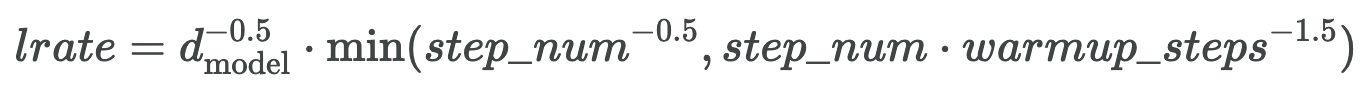
可以看到$step\_num^{-0.5}$是单调减函数，$step\_num*warmup\_steps^{-1.5}$是单调增函数，两者在$step\_num=warmup\_steps$时取等。

In [34]:
def rate(step, d_model, warmup_steps, factor = 1):
    if step == 0: # step^(-0.5) step不能取0
        step = 1
        
    return factor * (
        d_model ** (-0.5) * min(step ** (-0.5), step * warmup_steps ** (-1.5))
    )

n_step = 20000
d_model = 512
warmup_steps = 4000
lr = [0 for _ in range(n_step)]
for step in range(1, n_step + 1):
    lr[step-1] = rate(step, d_model, warmup_steps)
    
data  = pd.DataFrame({
    "step": range(1,n_step + 1),
    "lr": lr,
    "lrate": "lr"
})

alt.data_transformers.disable_max_rows()

alt.Chart(data).mark_line().encode(
    x="step",
    y="lr",
    color="lrate"
).interactive()

alt.Chart(...)

下面看看scheduler如何使用

In [35]:
dummy_model = nn.Linear(1,1)
optimizer = torch.optim.SGD(dummy_model.parameters(), lr=1)
scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer=optimizer, lr_lambda=lambda step: rate(step, d_model, warmup_steps)
)
lr = [0 for _ in range(n_step)]
for step in range(1, n_step+1):
    lr[step-1] = optimizer.param_groups[0]['lr']
    optimizer.step()
    scheduler.step()
    
data  = pd.DataFrame({
    "step": range(1,n_step + 1),
    "lr": lr,
    "lrate": "lr"
})

alt.data_transformers.disable_max_rows()

alt.Chart(data).mark_line().encode(
    x="step",
    y="lr",
    color="lrate"
).interactive()

alt.Chart(...)

## Label smoothing
为了加强模型的泛化能力，往往使用标签平滑技术，比如正确的类别是第二类(从零开始算类别)，一共有五类，则标签为\[0,0,1,0,0\]，经过平滑后标签可能变为\[0.1,0.1,0.6,0.1,0.1\]，即将概率从正确的类别中分一部分出来给别的类别。

In [36]:
def LabelSmoothing(target, vocab, padding = 0, smoothing = 0.2):
    # target: shape:(n) 一维向量，标注正确token，取值为[0,vocab)
    # padding: 填充token
    # vocab: 词表大小
    # smoothing: 分给非正确类的概率
    distr = torch.zeros(target.size(0), vocab) # 标签(distribution): shape: (n,vocab)
    distr.fill_(smoothing / (vocab - 2)) # 分给除去正确答案和padding的其他部分
    confidence = 1 - smoothing
    distr.scatter_(1,target.unsqueeze(-1),confidence)
    distr[:,padding] = 0
    pad_mask = target == padding
    distr[pad_mask, :] = 0 # target 为padding是无意义的标签
    return distr

target = torch.LongTensor([1,0,3,2,4,5])
LabelSmoothing(target, 6)

tensor([[0.0000, 0.8000, 0.0500, 0.0500, 0.0500, 0.0500],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0500, 0.0500, 0.8000, 0.0500, 0.0500],
        [0.0000, 0.0500, 0.8000, 0.0500, 0.0500, 0.0500],
        [0.0000, 0.0500, 0.0500, 0.0500, 0.8000, 0.0500],
        [0.0000, 0.0500, 0.0500, 0.0500, 0.0500, 0.8000]])

后文中使用KLDIVLoss作为损失函数，该损失函数计算方式见https://pytorch.org/docs/stable/generated/torch.nn.KLDivLoss.html#kldivloss 
在标签全为0时算出的loss为0. 封装计算损失的类如下

In [37]:
class LossCompute:
    def __init__(self, generator, smoothing = 0.2):
        self.generator = generator
        self.smoothing = smoothing
        self.KLDiv = nn.KLDivLoss(reduction='sum')

    def __call__(self, x, y, norm):
        # x: output of transformer. shape: (b, max_len, d_model).
        # y: (b,max_len) each element is a token
        x = self.generator(x) # x: (b, max_len, vocab)
        vocab = x.size(-1)
        x = x.reshape((-1,x.size(-1))) # (b*max_len, vocab)
        y = LabelSmoothing(y.reshape((-1,)), vocab, 0, self.smoothing) # (b, max_len)->(b*max_len)->(b*max_len, vocab)
        l = self.KLDiv(x,y)
        return (
            l, l/norm
        )

# 使用示例
test_model = make_model(6, 6)
src = torch.tensor([
    [1,2,3],
    [4,5,3]
])
tgt = torch.tensor([
    [1,2],
    [4,5]
])
tgt_x = tgt[:,:-1]
tgt_y = tgt[:,1:]

output = test_model(src, tgt_x, None, subsequent_mask(2))
loss = LossCompute(test_model.generator)
l1, l2 = loss(output, tgt_y, 2)
l1, l2

(tensor(3.4257, grad_fn=<KlDivBackward0>),
 tensor(1.7129, grad_fn=<DivBackward0>))

## training

将训练状态和跑一次epoch的代码封装如下

In [38]:
class TrainState:
    """Track number of steps, examples, and tokens processed"""

    step: int = 0  # Steps in the current epoch
    accum_step: int = 0  # Number of gradient accumulation steps
    samples: int = 0  # total # of examples used
    tokens: int = 0  # total # of tokens processed

def run_epoch(
    data_iter,
    model,
    loss_compute,
    optimizer,
    scheduler,
    mode="train",
    accum_iter=1,
    train_state=TrainState(),
):
    """Train a single epoch"""
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    n_accum = 0
    for i, batch in enumerate(data_iter):
        out = model.forward(
            batch.src, batch.tgt, batch.src_mask, batch.tgt_mask
        )
        loss, loss_node = loss_compute(out, batch.tgt_y, batch.ntokens)
        # loss_node = loss_node / accum_iter
        if mode == "train" or mode == "train+log":
            loss_node.backward()
            train_state.step += 1
            train_state.samples += batch.src.shape[0]
            train_state.tokens += batch.ntokens
            if i % accum_iter == 0:
                optimizer.step()
                optimizer.zero_grad(set_to_none=True)
                n_accum += 1
                train_state.accum_step += 1
            scheduler.step()

        total_loss += loss
        total_tokens += batch.ntokens
        tokens += batch.ntokens
        if i % 40 == 1 and (mode == "train" or mode == "train+log"):
            lr = optimizer.param_groups[0]["lr"]
            elapsed = time.time() - start
            print(
                (
                    "Epoch Step: %6d | Accumulation Step: %3d | Loss: %6.2f "
                    + "| Tokens / Sec: %7.1f | Learning Rate: %6.1e"
                )
                % (i, n_accum, loss / batch.ntokens, tokens / elapsed, lr)
            )
            start = time.time()
            tokens = 0
        del loss
        del loss_node
    return total_loss / total_tokens, train_state

## example: copy task

训练一个神经网络翻译太麻烦，一个是数据多我也没有GPU，另外暂时不能保证上面写的代码的正确性，并且麻烦。故先试试一个简单的复制任务，即希望decoder的输出和encoder输入一样。

In [39]:
def generate_data(vocab, batch_size, nbatches, max_len=10, debug=False):
    # 假设: <PAD>: 0  <BOS>: 1  <EOS>: 2
    for _ in range(nbatches):
        data = torch.randint(3, vocab, (batch_size, max_len + 2))
        data[:,0] = 1 # <BOS>
        eos = torch.randint(2, max_len+2, (batch_size, 1))
        pos = torch.arange(0, max_len + 2)
        data[pos >= eos] = 0 # padding
        src = data[:,1:-1].clone().detach()
        data.scatter_(1, eos, 2) # <EOS>

        if debug:
            print(f"data: {data}")
            print(f"rand_len: {eos}")
            print(f"pos: {pos}")
            print(f"src: {src}")
        yield Batch(src, data)

for b in generate_data(10, 5, 3):
    print("----------------")
    print(f"src: {b.src}")
    print(f"tgt: {b.tgt}")
    print(f"tgt_y: {b.tgt_y}")
    print("****************")

----------------
src: tensor([[3, 4, 0, 0, 0, 0, 0, 0, 0, 0],
        [5, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [7, 3, 7, 5, 4, 6, 3, 9, 6, 3],
        [5, 8, 7, 8, 0, 0, 0, 0, 0, 0],
        [3, 7, 4, 8, 9, 7, 3, 8, 3, 9]])
tgt: tensor([[1, 3, 4, 2, 0, 0, 0, 0, 0, 0, 0],
        [1, 5, 2, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 7, 3, 7, 5, 4, 6, 3, 9, 6, 3],
        [1, 5, 8, 7, 8, 2, 0, 0, 0, 0, 0],
        [1, 3, 7, 4, 8, 9, 7, 3, 8, 3, 9]])
tgt_y: tensor([[3, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0],
        [5, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [7, 3, 7, 5, 4, 6, 3, 9, 6, 3, 2],
        [5, 8, 7, 8, 2, 0, 0, 0, 0, 0, 0],
        [3, 7, 4, 8, 9, 7, 3, 8, 3, 9, 2]])
****************
----------------
src: tensor([[5, 7, 8, 4, 9, 9, 9, 4, 6, 6],
        [3, 9, 5, 7, 8, 5, 6, 5, 9, 0],
        [4, 4, 0, 0, 0, 0, 0, 0, 0, 0],
        [5, 6, 8, 6, 4, 9, 8, 6, 0, 0],
        [4, 4, 9, 5, 0, 0, 0, 0, 0, 0]])
tgt: tensor([[1, 5, 7, 8, 4, 9, 9, 9, 4, 6, 6],
        [1, 3, 9, 5, 7, 8, 5, 6, 5, 9, 2],
  

In [40]:
def trainCopyTask(conf):
    # conf is a dict contains keys:
    # batch_size nbatches max_len
    # warmup_steps d_model
    # vocab N
    model = make_model(conf["vocab"], conf["vocab"], conf["N"])
    model.train()

    for epoch in range(conf["epochs"]):
        print(f"Epoch: {epoch}")
        data = generate_data(conf["vocab"], conf["batch_size"], conf["nbatches"], conf["max_len"])
        loss_compute = LossCompute(model.generator)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.5, betas=(0.9, 0.98), eps=1e-9)
        scheduler = torch.optim.lr_scheduler.LambdaLR(
            optimizer=optimizer, lr_lambda=lambda step: rate(step, conf["d_model"], conf["warmup_steps"])
        )
        run_epoch(data, model, loss_compute, optimizer, scheduler, accum_iter=conf["accum_iter"])
        
    return model

conf = {
    "batch_size": 4000,
    "nbatches": 20,
    "max_len": 10,
    "warmup_steps": 4000,
    "d_model": 512,
    "vocab": 11,
    "N": 3,
    "epochs": 10,
    "accum_iter": 2
}

copy_model = trainCopyTask(conf)

Epoch: 0


RuntimeError: The size of tensor a (4000) must match the size of tensor b (32000) at non-singleton dimension 0

## 疑问
- FFN的d_ff是如何选的，为什么这么大？
- embedding乘以$\sqrt{d_{model}}$真的是防止加上positional embedding后原信息消失吗？
- Similarly to other sequence transduction models, we use learned embeddings to convert the input tokens and output tokens to vectors of dimension $d_{model}$. We also use the usual learned linear transformation and softmax function to convert the decoder output to predicted next-token probabilities. In our model, we share the same weight matrix between the two embedding layers and the pre-softmax linear transformation, similar to (https://arxiv.org/pdf/1608.05859.pdf); 这段说的“In our model, we share the same weight matrix between the two embedding layers and the pre-softmax linear transformation”我在代码中没看到体现呀